In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
pd.set_option('display.max_columns', 500)
import lightgbm as lgb

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [81]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df['channel_type'] = raw_df['channel_type'].fillna('type0')
raw_df.head()
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,type0,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,type0,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,type0,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,type0,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,type0,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [82]:
raw_df.drop(['target_sum'], axis=1,inplace=True)

In [83]:
raw_df['target_flag'].value_counts()

1    320103
0    170410
Name: target_flag, dtype: int64

In [84]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   PERIOD        490513 non-null  object 
 1   cl_id         490513 non-null  int64  
 2   MCC           490513 non-null  int64  
 3   channel_type  490513 non-null  object 
 4   currency      490513 non-null  int64  
 5   TRDATETIME    490513 non-null  object 
 6   amount        490513 non-null  float64
 7   trx_category  490513 non-null  object 
 8   target_flag   490513 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 33.7+ MB


In [85]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [86]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [87]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  395107
Total transactions in test dataset:  95406


#### Working with currency rates

In [88]:
codes = pd.read_csv('./codes-all.csv')
codes = codes[['NumericCode','AlphabeticCode']]
codes.columns = ['currency','AlphabeticCode']
codes = codes.dropna().reset_index(drop=True)
codes['currency'] = codes['currency'].astype('int')
codes = codes.drop_duplicates(subset=['currency']).reset_index(drop=True)
print(codes.shape)

(249, 2)


In [89]:
transactions_train = pd.merge(transactions_train, codes, how='left', on = 'currency')
transactions_test = pd.merge(transactions_test, codes, how='left', on = 'currency')

In [90]:
curr = pd.read_csv('./curr.csv')
curr['CLOSE'] = curr['CLOSE'] / curr['NOMINAL']
curr = curr[['TICKER','DATE','CLOSE']]
curr.columns = ['AlphabeticCode','time','CLOSE']
curr['time'] = pd.to_datetime(curr['time'])

### Determine most freq MCC for each user 

In [91]:
transactions_train['MCC'] = transactions_train['MCC'].astype('int')
transactions_test['MCC'] = transactions_test['MCC'].astype('int')

In [92]:
from scipy.stats import mode
def mode_count(x):
    return mode(x)[0][0][1]

In [93]:
d = transactions_train[['cl_id','MCC']].groupby('cl_id').apply(mode_count)

In [94]:
d = pd.DataFrame(d).reset_index()

In [95]:
d.columns = ['cl_id','mode_MCC']
transactions_train = pd.merge(transactions_train, d, how='left', on='cl_id')

In [96]:
d = transactions_test[['cl_id','MCC']].groupby('cl_id').apply(mode_count)
d = pd.DataFrame(d).reset_index()
d.columns = ['cl_id','mode_MCC']
transactions_test = pd.merge(transactions_test, d, how='left', on='cl_id')

### Transaction amount into neg/pos values 

In [97]:
transactions_train['amount'] = -transactions_train['amount']
ind = (transactions_train['trx_category']=='C2C_IN') | (transactions_train['trx_category']=='DEPOSIT') | (transactions_train['trx_category']=='BACK_TRX')
transactions_train['amount'][ind] = abs(transactions_train['amount'][ind])

transactions_test['amount'] = -transactions_test['amount']
ind = (transactions_test['trx_category']=='C2C_IN') | (transactions_test['trx_category']=='DEPOSIT') | (transactions_test['trx_category']=='BACK_TRX')
transactions_test['amount'][ind] = abs(transactions_test['amount'][ind])

<ipython-input-97-823ca6a1d665>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_train['amount'][ind] = abs(transactions_train['amount'][ind])
<ipython-input-97-823ca6a1d665>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_test['amount'][ind] = abs(transactions_test['amount'][ind])


In [98]:
from sklearn.preprocessing import LabelEncoder
cat_cols = ['channel_type','trx_category']
for i in ['channel_type','trx_category']:
    le = LabelEncoder()
    le.fit( pd.concat([transactions_train[[i]], transactions_test[[i]]], axis=0) )
    transactions_train[i] = le.transform(transactions_train[i])
    transactions_test[i] = le.transform(transactions_test[i])

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [99]:
transactions_train.shape

(395107, 11)

In [100]:
dt_dict = {
    'JAN':'01',
    'FEB':'02',
    'MAR':'03',
    'APR':'04',
    'MAY':'05', 
    'JUN':'06',  
    'JUL':'07',
    'AUG':'08',
    'SEP':'09',
    'OCT':'10',
    'NOV':'11', 
    'DEC':'12',   
}

In [101]:
def dt_preprocess1(t):
    day = t[0:2]
    month = dt_dict[t[2:5]]
    year = t[5:7]
    
    hour = t[8:10]
    minute = t[11:13]
    second = t[14:]
    
    return '20'+str(year)+'-'+str(month)+'-'+str(day)

In [102]:
transactions_train['time'] = transactions_train['TRDATETIME'].apply(lambda x: dt_preprocess1(x))
transactions_train['time'] = pd.to_datetime(transactions_train['time'])
transactions_test['time'] = transactions_test['TRDATETIME'].apply(lambda x: dt_preprocess1(x))
transactions_test['time'] = pd.to_datetime(transactions_train['time'])

In [103]:
def dt_preprocess(t):
    day = t[0:2]
    month = dt_dict[t[2:5]]
    year = t[5:7]
    
    hour = t[8:10]
    minute = t[11:13]
    second = t[14:]
    
    return '20'+str(year)+'-'+str(month)+'-'+str(day)+' '+str(hour)+":"+str(minute)+':'+str(second)

In [104]:
transactions_train['TRDATETIME'] = transactions_train['TRDATETIME'].apply(lambda x: dt_preprocess(x))
transactions_train['TRDATETIME'] = pd.to_datetime(transactions_train['TRDATETIME'])
transactions_test['TRDATETIME'] = transactions_test['TRDATETIME'].apply(lambda x: dt_preprocess(x))
transactions_test['TRDATETIME'] = pd.to_datetime(transactions_test['TRDATETIME'])

In [105]:
transactions_train['month'] = transactions_train['TRDATETIME'].dt.month + (transactions_train['TRDATETIME'].dt.year-2016)*12
transactions_test['month'] = transactions_test['TRDATETIME'].dt.month + (transactions_test['TRDATETIME'].dt.year-2016)*12

transactions_train['days_since2015'] = (transactions_train['TRDATETIME'] - pd.to_datetime('2015-01-01')).dt.days
transactions_test['days_since2015'] = (transactions_test['TRDATETIME'] - pd.to_datetime('2015-01-01')).dt.days

In [106]:
transactions_test = pd.merge(transactions_test, curr, how='left', on=['AlphabeticCode','time'])
transactions_train = pd.merge(transactions_train, curr, how='left', on=['AlphabeticCode','time'])

In [107]:
transactions_train['CLOSE'] = transactions_train['CLOSE'].fillna(1)
transactions_train['amount'] = transactions_train['amount'] * transactions_train['CLOSE']
transactions_train = transactions_train.drop(['currency', 'AlphabeticCode', 'CLOSE','time'], axis=1)

In [108]:
transactions_test['CLOSE'] = transactions_test['CLOSE'].fillna(1)
transactions_test['amount'] = transactions_test['amount'] * transactions_test['CLOSE']
transactions_test = transactions_test.drop(['currency', 'AlphabeticCode', 'CLOSE','time'], axis=1)

In [109]:
transactions_train.shape

(395107, 11)

### Merge df with cat cols

In [110]:
def diff_monthes(x):
    a = np.max(x) - np.min(x)
    return a.days

sum_deals = transactions_train[['cl_id','TRDATETIME']].groupby('cl_id').agg(diff_monthes).reset_index()
sum_deals.columns = ['cl_id','num_days_in_use']
df_train =  sum_deals

sum_deals = transactions_test[['cl_id','TRDATETIME']].groupby('cl_id').agg(diff_monthes).reset_index()
sum_deals.columns = ['cl_id','num_days_in_use']
df_test =  sum_deals

##### Средние значения по MCC и каналу привлечения

In [111]:
def mmode(x):
    return mode(x)[0][0]

In [112]:
for i in tqdm(['channel_type', 'mode_MCC']):
    temp = transactions_train[['cl_id',i]].groupby('cl_id').agg(mmode).reset_index()
    
    temp = pd.DataFrame(temp.values)
    new_cols = ['cl_id',i]

    temp.columns = new_cols
    df = temp
df_train = pd.merge(df_train, temp, how='left', on='cl_id')

100%|████████████████████████████████████████████| 2/2 [00:01<00:00,  1.84it/s]


In [113]:
for i in tqdm(['channel_type', 'mode_MCC']):
    temp = transactions_test[['cl_id',i]].groupby('cl_id').agg(mmode).reset_index()
    
    temp = pd.DataFrame(temp.values)
    new_cols = ['cl_id',i]

    temp.columns = new_cols
    df = temp
df_test = pd.merge(df_test, temp, how='left', on='cl_id')

100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


In [114]:
num_deals = transactions_train[['cl_id','amount']].groupby('cl_id').agg('count').reset_index()
num_deals.columns = ['cl_id','num_deals']
df_train = pd.merge(df_train, num_deals, how='left', on='cl_id')

sum_deals = transactions_train[['cl_id','amount']].groupby('cl_id').agg('sum').reset_index()
sum_deals.columns = ['cl_id','sum_deals']
df_train = pd.merge(df_train, sum_deals, how='left', on='cl_id')

In [115]:
num_deals = transactions_test[['cl_id','amount']].groupby('cl_id').agg('count').reset_index()
num_deals.columns = ['cl_id','num_deals']
df_test = pd.merge(df_test, num_deals, how='left', on='cl_id')

sum_deals = transactions_test[['cl_id','amount']].groupby('cl_id').agg('sum').reset_index()
sum_deals.columns = ['cl_id','sum_deals']
df_test = pd.merge(df_test, sum_deals, how='left', on='cl_id')

In [116]:
test_y = transactions_test[['cl_id','target_flag']].groupby('cl_id').agg('mean').reset_index()
test_y.columns = ['cl_id','target_flag']
df_test = pd.merge(df_test, test_y, how='left', on='cl_id')

### Разложение категорий транзакций

In [117]:
to_agg = ['sum','mean','std','median','max','min','count']
for j in tqdm(pd.unique(transactions_test['trx_category'])):
    i = 'amount'
    temp = transactions_test[transactions_test['trx_category']==j][['cl_id',i]].groupby('cl_id').agg(to_agg).reset_index().fillna(0)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append('trx_category'+'_'+str(j)+'_'+i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df_test = pd.merge(df_test, temp, how='left', on='cl_id')

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 70.66it/s]


In [118]:
#def mode_count(x):
#    return mode(x)[1][0]
to_agg = ['sum','mean','std','median','max','min','count']
for j in tqdm(pd.unique(transactions_train['trx_category'])):
    i = 'amount'
    temp = transactions_train[transactions_train['trx_category']==j][['cl_id',i]].groupby('cl_id').agg(to_agg).reset_index().fillna(0)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append('trx_category'+'_'+str(j)+'_'+i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df_train = pd.merge(df_train, temp, how='left', on='cl_id')
    #df[str(j)+'_'+i+'_'+'count_frac'] = df[str(j)+'_'+i+'_'+'count'] / df['num_deals']

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 47.50it/s]


In [119]:
target_flag_train = transactions_train[['cl_id','target_flag']].groupby('cl_id').mean().reset_index()
target_flag_train.columns = ['cl_id','target_flag']
df_train = pd.merge(df_train, target_flag_train, how='left', on='cl_id')

### Работа над разложением MCC кодов на фичи и их разложение на главные компоненты

In [120]:
df_train_MCC = pd.DataFrame(df_train.cl_id)
df_test_MCC = pd.DataFrame(df_test.cl_id)

In [121]:
for j in tqdm(pd.unique(transactions_train['MCC'])):
    i = 'amount'
    temp = transactions_train[transactions_train['MCC']==j][['cl_id',i]].groupby('cl_id').agg('sum').reset_index().fillna(0)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append('MCC'+'_'+str(j)+'_'+i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df_train_MCC = pd.merge(df_train_MCC, temp, how='left', on='cl_id')

100%|████████████████████████████████████████| 334/334 [00:12<00:00, 27.76it/s]


In [122]:
for j in tqdm(pd.unique(transactions_test['MCC'])):
    i = 'amount'
    temp = transactions_test[transactions_test['MCC']==j][['cl_id',i]].groupby('cl_id').agg('sum').reset_index().fillna(0)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append('MCC'+'_'+str(j)+'_'+i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df_test_MCC = pd.merge(df_test_MCC, temp, how='left', on='cl_id')

100%|████████████████████████████████████████| 253/253 [00:06<00:00, 41.84it/s]


In [123]:
df_train_MCC = df_train_MCC[df_train_MCC.columns & df_test_MCC.columns]
df_test_MCC = df_train_MCC[df_train_MCC.columns & df_test_MCC.columns]

In [124]:
df_train_MCC_PCA = df_train_MCC
df_test_MCC_PCA = df_test_MCC

##### PCA  (исключается , если использовать начальные фичи)

In [125]:
from sklearn.decomposition import PCA
pca = PCA().fit(df_train_MCC_PCA.fillna(0).drop(['cl_id'], axis=1))

(0.9, 1.0)

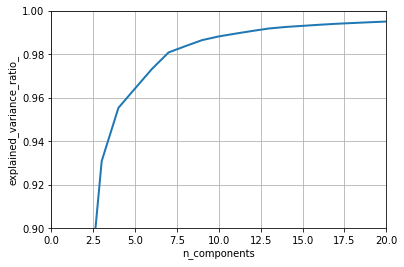

In [126]:
cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.xlim([0, 20])
plt.ylim([0.9, 1])

In [127]:
np.set_printoptions(suppress=True)
#pca.explained_variance_ratio_ * 100

#### For using main components

In [128]:
pca = PCA(n_components=15)

principalComponents = pca.fit_transform(df_train_MCC_PCA.fillna(0).drop(['cl_id'], axis=1))
df_train_MCC_PCA = pd.DataFrame(data = principalComponents , columns = ['p_c_1', 'p_c_2','p_c_3', 'p_c_4','p_c_5', 'p_c_6','p_c_7', 'p_c_8','p_c_9', 'p_c_10','p_c_11', 'p_c_12','p_c_13','p_c_14','p_c_15'])
df_train_MCC_PCA['cl_id'] = df_train['cl_id']

In [129]:
principalComponents = pca.fit_transform(df_test_MCC_PCA.fillna(0).drop(['cl_id'], axis=1))
df_test_MCC_PCA = pd.DataFrame(data = principalComponents , columns = ['p_c_1', 'p_c_2','p_c_3', 'p_c_4','p_c_5', 'p_c_6','p_c_7', 'p_c_8','p_c_9', 'p_c_10','p_c_11', 'p_c_12','p_c_13','p_c_14','p_c_15'])
df_test_MCC_PCA['cl_id'] = df_test['cl_id']

In [130]:
#df_train = pd.merge(df_train, df_train_MCC_PCA, how='left', on='cl_id') # For using main components
#df_test = pd.merge(df_test, df_test_MCC_PCA, how='left', on='cl_id') # For using main components
df_train = pd.merge(df_train, df_train_MCC, how='left', on='cl_id') # For not using main components
df_test = pd.merge(df_test, df_test_MCC, how='left', on='cl_id') # For not using main components

#USE both for if you want more depression


In [131]:
#df_train_MCC   #use this for only main components for MCC
#df_test_MCC

In [132]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

### Работа с датами

In [133]:
month = transactions_train[['cl_id','month']].groupby('cl_id').mean().reset_index()
month.columns = ['cl_id','month']
df_train = pd.merge(df_train, month, how='left', on='cl_id')

month = transactions_test[['cl_id','month']].groupby('cl_id').mean().reset_index()
month.columns = ['cl_id','month']
df_test = pd.merge(df_test, month, how='left', on='cl_id')

days_since2015 = transactions_train[['cl_id','days_since2015']].groupby('cl_id').mean().reset_index()
days_since2015.columns = ['cl_id','days_since2015']
df_train = pd.merge(df_train, days_since2015, how='left', on='cl_id')

days_since2015 = transactions_test[['cl_id','days_since2015']].groupby('cl_id').mean().reset_index()
days_since2015.columns = ['cl_id','days_since2015']
df_test = pd.merge(df_test, days_since2015, how='left', on='cl_id')

In [134]:
channel_type = transactions_train[['cl_id','channel_type']].groupby('cl_id').mean().reset_index()
channel_type.columns = ['cl_id','channel_type']
df_train = pd.merge(df_train, channel_type, how='left', on='cl_id')

channel_type = transactions_test[['cl_id','channel_type']].groupby('cl_id').mean().reset_index()
channel_type.columns = ['cl_id','channel_type']
df_test = pd.merge(df_test, channel_type, how='left', on='cl_id')

In [135]:
#for i in ['mode_MCC', 'channel_type']:
#    d = transactions_train[['target_flag',i]].groupby(i).agg('mean')['target_flag'].to_dict()
#    transactions_train[i] = transactions_train[i].replace(d)
#    transactions_test[i] = transactions_test[i].replace(d)

In [136]:
df_train = df_train[df_train.columns & df_test.columns]
df_test = df_test[df_train.columns & df_test.columns]

In [137]:
df_train.drop(['cl_id'], axis=1)

,num_days_in_use,mode_MCC,num_deals,sum_deals,trx_category_6_amount_sum,trx_category_6_amount_mean,trx_category_6_amount_std,trx_category_6_amount_median,trx_category_6_amount_max,trx_category_6_amount_min,trx_category_6_amount_count,trx_category_5_amount_sum,trx_category_5_amount_mean,trx_category_5_amount_std,trx_category_5_amount_median,trx_category_5_amount_max,trx_category_5_amount_min,trx_category_5_amount_count,trx_category_2_amount_sum,trx_category_2_amount_mean,trx_category_2_amount_std,trx_category_2_amount_median,trx_category_2_amount_max,trx_category_2_amount_min,trx_category_2_amount_count,trx_category_9_amount_sum,trx_category_9_amount_mean,trx_category_9_amount_std,trx_category_9_amount_median,trx_category_9_amount_max,trx_category_9_amount_min,trx_category_9_amount_count,trx_category_0_amount_sum,trx_category_0_amount_mean,trx_category_0_amount_std,trx_category_0_amount_median,trx_category_0_amount_max,trx_category_0_amount_min,trx_category_0_amount_count,trx_category_8_amount_sum,trx_category_8_amount_mean,trx_category_8_amount_std,trx_category_8_amount_median,trx_category_8_amount_max,trx_category_8_amount_min,trx_category_8_amount_count,trx_category_7_amount_sum,trx_category_7_amount_mean,trx_category_7_amount_std,trx_category_7_amount_median,trx_category_7_amount_max,trx_category_7_amount_min,trx_category_7_amount_count,trx_category_1_amount_sum,trx_category_1_amount_mean,trx_category_1_amount_std,trx_category_1_amount_median,trx_category_1_amount_max,trx_category_1_amount_min,trx_category_1_amount_count,trx_category_4_amount_sum,trx_category_4_amount_mean,trx_category_4_amount_std,trx_category_4_amount_median,trx_category_4_amount_max,trx_category_4_amount_min,trx_category_4_amount_count,trx_category_3_amount_sum,trx_category_3_amount_mean,trx_category_3_amount_std,trx_category_3_amount_median,trx_category_3_amount_max,trx_category_3_amount_min,trx_category_3_amount_count,target_flag,MCC_5200_amount_sum,MCC_6011_amount_sum,MCC_5921_amount_sum,MCC_5411_amount_sum,MCC_6012_amount_sum,MCC_5814_amount_sum,MCC_4111_amount_sum,MCC_5812_amount_sum,MCC_5661_amount_sum,MCC_7996_amount_sum,MCC_5947_amount_sum,MCC_5691_amount_sum,MCC_5813_amount_sum,MCC_7991_amount_sum,MCC_7399_amount_sum,MCC_4468_amount_sum,MCC_5999_amount_sum,MCC_5811_amount_sum,MCC_5912_amount_sum,MCC_5942_amount_sum,MCC_9311_amount_sum,MCC_5977_amount_sum,MCC_7832_amount_sum,MCC_5499_amount_sum,MCC_5651_amount_sum,MCC_5944_amount_sum,MCC_5621_amount_sum,MCC_4112_amount_sum,MCC_5735_amount_sum,MCC_5995_amount_sum,MCC_5331_amount_sum,MCC_7230_amount_sum,MCC_7922_amount_sum,MCC_4131_amount_sum,MCC_4814_amount_sum,MCC_8011_amount_sum,MCC_5722_amount_sum,MCC_4722_amount_sum,MCC_5941_amount_sum,MCC_4511_amount_sum,MCC_5641_amount_sum,MCC_7011_amount_sum,MCC_9222_amount_sum,MCC_5211_amount_sum,MCC_7299_amount_sum,MCC_5993_amount_sum,MCC_5533_amount_sum,MCC_5655_amount_sum,MCC_5983_amount_sum,MCC_5992_amount_sum,MCC_5541_amount_sum,MCC_7531_amount_sum,MCC_4829_amount_sum,MCC_5251_amount_sum,MCC_8999_amount_sum,MCC_5311_amount_sum,MCC_5732_amount_sum,MCC_8099_amount_sum,MCC_5699_amount_sum,MCC_5943_amount_sum,MCC_4812_amount_sum,MCC_5712_amount_sum,MCC_7542_amount_sum,MCC_8062_amount_sum,MCC_5714_amount_sum,MCC_5611_amount_sum,MCC_5462_amount_sum,MCC_5451_amount_sum,MCC_7997_amount_sum,MCC_4011_amount_sum,MCC_8071_amount_sum,MCC_7512_amount_sum,MCC_5261_amount_sum,MCC_7278_amount_sum,MCC_7311_amount_sum,MCC_9211_amount_sum,MCC_7298_amount_sum,MCC_6300_amount_sum,MCC_4900_amount_sum,MCC_5964_amount_sum,MCC_5192_amount_sum,MCC_5945_amount_sum,MCC_5111_amount_sum,MCC_5441_amount_sum,MCC_5719_amount_sum,MCC_5631_amount_sum,MCC_8043_amount_sum,MCC_6051_amount_sum,MCC_4784_amount_sum,MCC_7538_amount_sum,MCC_7032_amount_sum,MCC_7523_amount_sum,MCC_5399_amount_sum,MCC_3011_amount_sum,MCC_7216_amount_sum,MCC_5946_amount_sum,MCC_7221_amount_sum,MCC_5300_amount_sum,MCC_8299_amount_sum,MCC_9399_amount_sum,MCC_4121_amount_sum,MCC_8021_amount_sum,MCC_6010_amount_sum,MC

In [138]:
df_test.drop(['cl_id'], axis=1)

,num_days_in_use,mode_MCC,num_deals,sum_deals,trx_category_6_amount_sum,trx_category_6_amount_mean,trx_category_6_amount_std,trx_category_6_amount_median,trx_category_6_amount_max,trx_category_6_amount_min,trx_category_6_amount_count,trx_category_5_amount_sum,trx_category_5_amount_mean,trx_category_5_amount_std,trx_category_5_amount_median,trx_category_5_amount_max,trx_category_5_amount_min,trx_category_5_amount_count,trx_category_2_amount_sum,trx_category_2_amount_mean,trx_category_2_amount_std,trx_category_2_amount_median,trx_category_2_amount_max,trx_category_2_amount_min,trx_category_2_amount_count,trx_category_9_amount_sum,trx_category_9_amount_mean,trx_category_9_amount_std,trx_category_9_amount_median,trx_category_9_amount_max,trx_category_9_amount_min,trx_category_9_amount_count,trx_category_0_amount_sum,trx_category_0_amount_mean,trx_category_0_amount_std,trx_category_0_amount_median,trx_category_0_amount_max,trx_category_0_amount_min,trx_category_0_amount_count,trx_category_8_amount_sum,trx_category_8_amount_mean,trx_category_8_amount_std,trx_category_8_amount_median,trx_category_8_amount_max,trx_category_8_amount_min,trx_category_8_amount_count,trx_category_7_amount_sum,trx_category_7_amount_mean,trx_category_7_amount_std,trx_category_7_amount_median,trx_category_7_amount_max,trx_category_7_amount_min,trx_category_7_amount_count,trx_category_1_amount_sum,trx_category_1_amount_mean,trx_category_1_amount_std,trx_category_1_amount_median,trx_category_1_amount_max,trx_category_1_amount_min,trx_category_1_amount_count,trx_category_4_amount_sum,trx_category_4_amount_mean,trx_category_4_amount_std,trx_category_4_amount_median,trx_category_4_amount_max,trx_category_4_amount_min,trx_category_4_amount_count,trx_category_3_amount_sum,trx_category_3_amount_mean,trx_category_3_amount_std,trx_category_3_amount_median,trx_category_3_amount_max,trx_category_3_amount_min,trx_category_3_amount_count,target_flag,MCC_5200_amount_sum,MCC_6011_amount_sum,MCC_5921_amount_sum,MCC_5411_amount_sum,MCC_6012_amount_sum,MCC_5814_amount_sum,MCC_4111_amount_sum,MCC_5812_amount_sum,MCC_5661_amount_sum,MCC_7996_amount_sum,MCC_5947_amount_sum,MCC_5691_amount_sum,MCC_5813_amount_sum,MCC_7991_amount_sum,MCC_7399_amount_sum,MCC_4468_amount_sum,MCC_5999_amount_sum,MCC_5811_amount_sum,MCC_5912_amount_sum,MCC_5942_amount_sum,MCC_9311_amount_sum,MCC_5977_amount_sum,MCC_7832_amount_sum,MCC_5499_amount_sum,MCC_5651_amount_sum,MCC_5944_amount_sum,MCC_5621_amount_sum,MCC_4112_amount_sum,MCC_5735_amount_sum,MCC_5995_amount_sum,MCC_5331_amount_sum,MCC_7230_amount_sum,MCC_7922_amount_sum,MCC_4131_amount_sum,MCC_4814_amount_sum,MCC_8011_amount_sum,MCC_5722_amount_sum,MCC_4722_amount_sum,MCC_5941_amount_sum,MCC_4511_amount_sum,MCC_5641_amount_sum,MCC_7011_amount_sum,MCC_9222_amount_sum,MCC_5211_amount_sum,MCC_7299_amount_sum,MCC_5993_amount_sum,MCC_5533_amount_sum,MCC_5655_amount_sum,MCC_5983_amount_sum,MCC_5992_amount_sum,MCC_5541_amount_sum,MCC_7531_amount_sum,MCC_4829_amount_sum,MCC_5251_amount_sum,MCC_8999_amount_sum,MCC_5311_amount_sum,MCC_5732_amount_sum,MCC_8099_amount_sum,MCC_5699_amount_sum,MCC_5943_amount_sum,MCC_4812_amount_sum,MCC_5712_amount_sum,MCC_7542_amount_sum,MCC_8062_amount_sum,MCC_5714_amount_sum,MCC_5611_amount_sum,MCC_5462_amount_sum,MCC_5451_amount_sum,MCC_7997_amount_sum,MCC_4011_amount_sum,MCC_8071_amount_sum,MCC_7512_amount_sum,MCC_5261_amount_sum,MCC_7278_amount_sum,MCC_7311_amount_sum,MCC_9211_amount_sum,MCC_7298_amount_sum,MCC_6300_amount_sum,MCC_4900_amount_sum,MCC_5964_amount_sum,MCC_5192_amount_sum,MCC_5945_amount_sum,MCC_5111_amount_sum,MCC_5441_amount_sum,MCC_5719_amount_sum,MCC_5631_amount_sum,MCC_8043_amount_sum,MCC_6051_amount_sum,MCC_4784_amount_sum,MCC_7538_amount_sum,MCC_7032_amount_sum,MCC_7523_amount_sum,MCC_5399_amount_sum,MCC_3011_amount_sum,MCC_7216_amount_sum,MCC_5946_amount_sum,MCC_7221_amount_sum,MCC_5300_amount_sum,MCC_8299_amount_sum,MCC_9399_amount_sum,MCC_4121_amount_sum,MCC_8021_amount_sum,MCC_6010_amount_sum,MC

In [139]:
corr_matrix = df_train.corr()
corr = corr_matrix["target_flag"].sort_values(ascending=False)
corr

target_flag                    1.000000
channel_type                   0.262390
num_days_in_use                0.262019
num_deals                      0.244929
trx_category_6_amount_count    0.234650
                                 ...   
MCC_5411_amount_sum           -0.101857
trx_category_5_amount_count   -0.118282
MCC_5661_amount_sum           -0.135241
MCC_5814_amount_sum           -0.164610
cl_id                         -0.401701
Name: target_flag, Length: 322, dtype: float64

### Lasso LogisticRegression

In [140]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression( penalty='l1', solver='liblinear')
log.fit(df_train.drop(['target_flag'],axis=1),df_train['target_flag'])

D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LogisticRegression(penalty='l1', solver='liblinear')

In [141]:
y_pred_Lasso = log.predict(df_test.drop(['target_flag'],axis=1))

In [142]:
from sklearn.metrics import accuracy_score
accuracy_score(df_test[['target_flag']], y_pred_Lasso)

0.703

In [143]:
from sklearn.metrics import r2_score
r2_score(df_test[['target_flag']], y_pred_Lasso)

-0.1935188310748901

In [144]:
from sklearn.metrics import average_precision_score
average_precision_score = average_precision_score( df_test[['target_flag']], y_pred_Lasso)
average_precision_score

0.6960351738610919

##### accuracy = 0,77225   R2 =0.0758   precision =0.750   - without main components
##### accuracy = 0,74525  R2 = -0.02  precision = 0.718  - with only main components
##### accuracy = 0,7775  R2 = 0.0987  precision = 0.753  - with both

In [145]:
print(log .intercept_)
print(log .coef_)

[-0.1001982]
[[-0.00022595  0.01438321 -0.00000075  0.00127514  0.00000026  0.
   0.00000336 -0.00001145  0.00000715 -0.0000045  -0.00000164  0.00162148
   0.00000155 -0.00000426 -0.00001126  0.00000571 -0.00000074 -0.00000248
  -0.07666408 -0.00000172  0.0000236   0.00002026  0.00000379 -0.00002056
  -0.00000058 -0.00572423  0.00000071 -0.00000283 -0.00000491  0.0000012
   0.00000467 -0.00000393  0.04643946  0.00000817 -0.00000794 -0.00001705
  -0.00000677  0.00000465 -0.00000036 -0.06355622  0.00000098  0.00000071
  -0.00000391  0.0000048   0.         -0.00000446  0.05793277  0.00000087
  -0.00000318 -0.00000273 -0.00000429  0.00000221  0.00000171  0.09733698
  -0.00000242  0.00001305 -0.00001587  0.0000028   0.00000047 -0.00001958
  -0.019749   -0.00000618 -0.00001436  0.00000679  0.00000799  0.00001139
   0.00001355  0.06146407  0.00000105  0.00000226 -0.00008137  0.000001
  -0.00003776 -0.0000002   0.          0.00000473  0.0000002  -0.00000923
  -0.0000039   0.00000168 -0.0000105

### LGBModel

In [146]:
from sklearn.model_selection import RepeatedStratifiedKFold
skf = RepeatedStratifiedKFold(n_splits=8, n_repeats=5, random_state=201805)

In [147]:
lgb_data_train = lgb.Dataset(df_train.drop(['target_flag'],axis=1), 
                             df_train['target_flag'], 
                             free_raw_data=False
                            )

params = {
    'objective':'binary', 
    'metric': 'auc',
    'learning_rate': 0.01, 
    'random_state':4242442,
    'subsample':0.33,
    'class_weight':'balanced',
    'colsample_bytree':0.33,
    'reg_lambda':4
}

h = lgb.cv(params, 
           lgb_data_train, 
           num_boost_round=10000,
           early_stopping_rounds=50, 
           verbose_eval=10, 
           folds=skf.split(df_train, df_train['target_flag'])
          )

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1954, number of negative: 1546
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28435
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 212
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1954, number of negative: 1546
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1954, number of negative: 1546
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28435
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 212
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1954, number of negative: 1546
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28435
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 212
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] 

[LightGBM] [Info] Start training from score 0.234208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.558286 -> initscore=0.234208
[LightGBM] [Info] Start training from score 0.234208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.558286 -> initscore=0.234208
[LightGBM] [Info] Start training from score 0.234208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.558286 -> initscore=0.234208
[LightGBM] [Info] Start training from score 0.234208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.558286 -> initscore=0.234208
[LightGBM] [Info] Start training from score 0.234208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.558286 -> initscore=0.234208
[LightGBM] [Info] Start training from score 0.234208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.558286 -> initscore=0.234208
[LightGBM] [Info] Start training from score 0.234208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.558000 -> initscore=0.233049
[LightGBM] [Info] Start training from score 0.233049
[LightGBM] [Info] [bina

In [156]:
model = lgb.train(params, lgb_data_train, num_boost_round=880)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 2233, number of negative: 1767
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28435
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.558250 -> initscore=0.234063
[LightGBM] [Info] Start training from score 0.234063


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

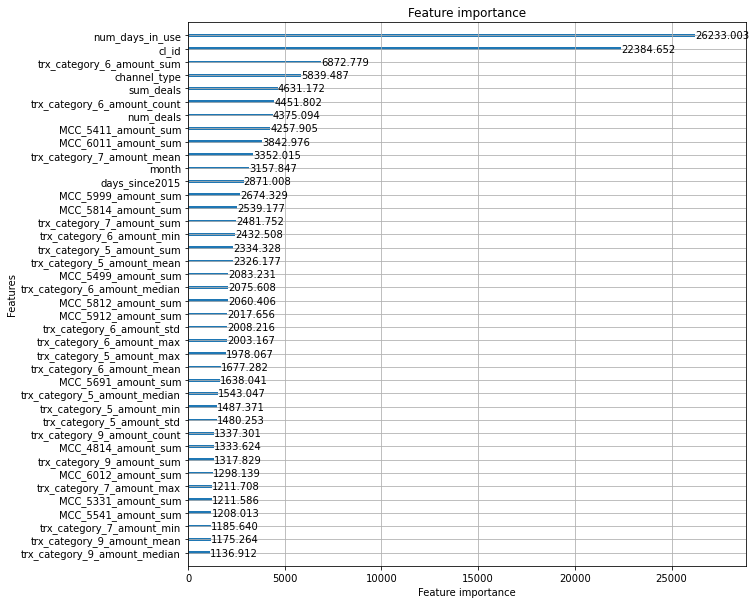

In [157]:
lgb.plot_importance(model, figsize=(10,10), importance_type='gain', max_num_features=40)

num_deals = transactions_test[['cl_id','amount']].groupby('cl_id').agg('count').reset_index()
num_deals.columns = ['cl_id','num_deals']
num_deals.head()

sum_deals = transactions_test[['cl_id','amount']].groupby('cl_id').agg('sum').reset_index()
sum_deals.columns = ['cl_id','sum_deals']
df_test = pd.merge(num_deals, sum_deals, how='left', on='cl_id')
sum_deals.head()

test_y = transactions_test[['cl_id','target_flag']].groupby('cl_id').agg('mean').reset_index()
test_y.columns = ['cl_id','target_flag']
df_test = pd.merge(df_test, test_y, how='left', on='cl_id')
df_test.head()

to_agg = ['sum','mean','std','median','max','min','count']
for j in tqdm(pd.unique(transactions_test['trx_category'])):
    i = 'amount'
    temp = transactions_test[transactions_test['trx_category']==j][['cl_id',i]].groupby('cl_id').agg(to_agg).reset_index().fillna(0)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append('trx_category'+'_'+str(j)+'_'+i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df_test = pd.merge(df_test, temp, how='left', on='cl_id')

In [158]:
df_test = df_test.fillna(0)
#df_test.info()

In [159]:
y_hat = model.predict(df_test.drop(['target_flag'],axis=1))
sub = pd.DataFrame({
    '_ID_':df_test['cl_id'],
    '_VAL_': y_hat
})
sub.to_csv('1.csv',index=False)

In [160]:
sub.head()

,_ID_,_VAL_
0,14,0.658519
1,20,0.345832
2,46,0.208217
3,52,0.651097
4,69,0.350755


In [161]:
from sklearn.metrics import r2_score
r2_score(df_test[['target_flag']], y_hat)

0.3012986360492018

In [162]:
from sklearn.metrics import average_precision_score
average_precision_score = average_precision_score( df_test[['target_flag']], y_hat )
average_precision_score

0.861211872750917

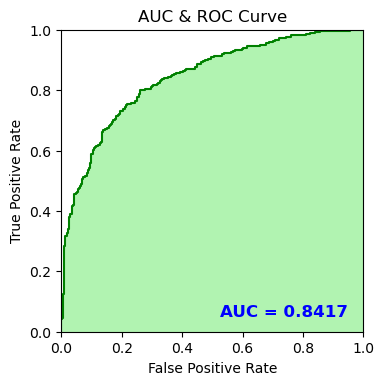

In [163]:
from sklearn import metrics
auc = metrics.roc_auc_score( df_test[['target_flag']], y_hat )

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve( df_test[['target_flag']], y_hat )

plt.figure(figsize=(5, 4), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

##### AUC not using PCA:         AUC= 0.9769  R2 = 0.697   - without main components
##### AUC only using PCA:        AUC= 0.9730  R2 = 0.697   - without main components
##### AUC PCA+ Primal MCC:     AUC= 0.9730  R2 = 0.697   - without main components